In [109]:
# Auteurs : Mehran ASADI  (1047847)
#           Lenny SIEMENI (1055234)
#           Bilal DAHER   (20069251)
#           Gabriel TO    (20070050)

# IFT3700 - Sciences de donnees - Devoir 1 

# Ce devoir nous a pris beaucoup de temps et avons effectue beaucoup de recherches. Bien qu'il soit normal que certains
# aspects aient trouves leur inspiration depuis la librairie Scikit, nous avons mis en bas de page toutes le references
# qui nous ont permis de comprendre et/ou qui nous on aide a realiser ce travail.

# K-NN : Choisir les bons hyperparametres

Dans l'ensemble de donnees **MNIST (notemment celui depuis la librairie Scikit qui est plus restrain)**, nous pouvons nous permettre de choisir un ensemble d'apprentissage beaucoup plus important que l'ensemble de validation. Ceci est essentiellement du au fait que MNIST possede 10 categories différentes, et que nous avons donc un jeu de données restreint (puisque nous travaillons avec une version MNIST reduite depuis les librairies Scikit-learn). 

In [110]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
#from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering

#Extraire les donnees MNIST
digits = load_digits()
data = scale(digits.data)
#data = digits.data
n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

print("n_digits: %d, \t n_samples: %d, \t n_features: %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples: 1797, 	 n_features: 64


Tandis que le jeu **MNIST complet** comporte plus de 60000 exemples 
constitué de 785 valeurs d'une image de 28 par 28.

Il faut cependant que nous trouvions les hyperparametres de notre classificateur. Commencons par determiner quelle est la valeur de k (soit le nombre de voisins que l'on considere pour chaque point du modele) qui retourne la plus grande precision.

La valeur de k ayant la plus grande precision est : k=5 de 97.78%


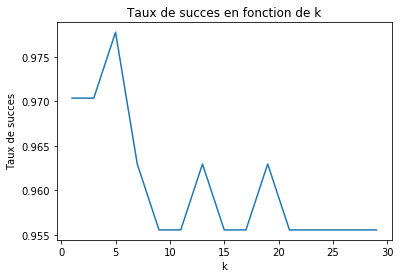

In [111]:
#Pretraitement des donnees pour knn, on divise notre ensemble de validation et d'entrainement
# 75% pour l'entrainement et 25% pour le test
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(digits.data), digits.target, test_size=0.25, random_state=np.random.seed(56))

# Notre ensenble de validation, 10% restants
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels, test_size=0.1, random_state=np.random.seed(84))

# initialise un vecteur contenant les precisions maximales pour un classificateur utilisant K-NN
kVals = range(1, 30, 2)
precision_vector = []

# loop over kVals
for k in kVals:
	# Entraine le classificateur avec la valeur de k actuelle of `k`
	model = KNeighborsClassifier(n_neighbors=k)
	model.fit(trainData, trainLabels)
	precision = model.score(valData, valLabels)
	precision_vector.append(precision)

plt.plot(kVals, precision_vector)
plt.xlabel('k')
plt.ylabel('Taux de succes')
plt.title('Taux de succes en fonction de k');
    
# Retourne la plus grande precision
i = np.argmax(precision_vector)
print("La valeur de k ayant la plus grande precision est : k=%d de %.2f%%" % (kVals[i],
	precision_vector[i] * 100))


Enfin le nombre de groupes (clusters) devrait etre de 10, soit les chiffres de 0 a 9 bien evidemment.

# K-means : Converger vers la meilleure approche

Pour K-moyennes, lorsque nous n'effectuons **pas de pre-traitement sur les données**, il existe plusieurs manieres
de rendre la disposition des centroides aleatoires, puisque nous effectuons un apprentissage non supervise. D'apres la documentation de Scikit-learn, nous pouvons lancer plusieurs fois l'algorithme et utiliser le modele ayant la meilleure convergence. Nous pouvons aussi decider de choisir un ensemble de centroides qui maximisent et accelerent la convergence. C'est l'approche que nous avons choisit ici et c'est pourquoi nous avaons 2 versions de K-means (K-means++ et random), pour observer leur comportement en fonction de comment sont initialises les centroides.

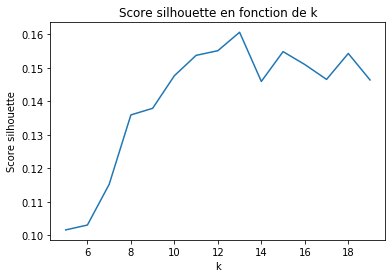

In [112]:
# Score silhouette selon notre jeu des donnees MNIST appliquees a K-means (methode inspiree de la demo 2)
scores = []
k_range = range(5,20)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(data)
    scores.append(silhouette_score(data, y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k');

### Apercu des donnees MNIST a titre illustratif

En ayant effectue une reduction de dimensionnalite par **PCA**, exemple inspire de Scikit-learn.

<Figure size 432x288 with 0 Axes>

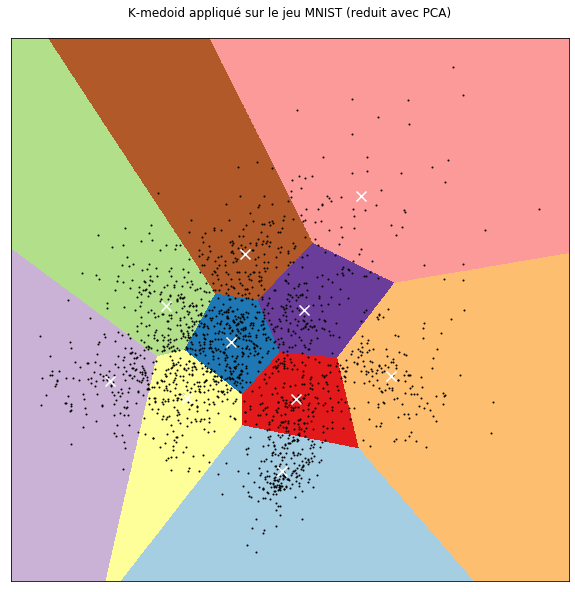

In [113]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

h = .01

# Tracage des frontieres de decision
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# On affiche le resultat sous forme de graphique a nuage de points
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.figure(figsize = (10,10))
plt.imshow(Z, interpolation='nearest',
					 extent=(xx.min(), xx.max(), yy.min(), yy.max()),
					 cmap=plt.cm.Paired,
					 aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Affichage des centroides
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
						marker='x', s=100, linewidths=3,
						color='w', zorder=10)
plt.title('K-medoid appliqué sur le jeu MNIST (reduit avec PCA)\n')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


# Partitionnement binaire (hiérarchique)

Pour la partition binaire, on utilise l’algorithme de la classification ascendante hiérarchique(hierarchical agglomerative clustering) avec la variation basée sur la moyenne des distances(average linkage).
On crée d’abord le dendrogramme avec les données de MNIST et normalement, on utilise ce graphique afin de trouver le nombre de clusters à mettre comme paramètre. Par contre, puisque dans notre cas, nous savons
déjà qu’il y aura dix clusters (dix chiffres), on passe à créer le regroupement hiérarchique. D’abord, on utilise les données de mnist pour créer une matrice de similarité en 2D puisque l’algorithme HAC de la
librairie scikit doit prendre une matrice x par deux. On a normalisé les données car il est avisé de le faire avant de créer les clusters pour être sûr que les distances soient dans la même intervalle.

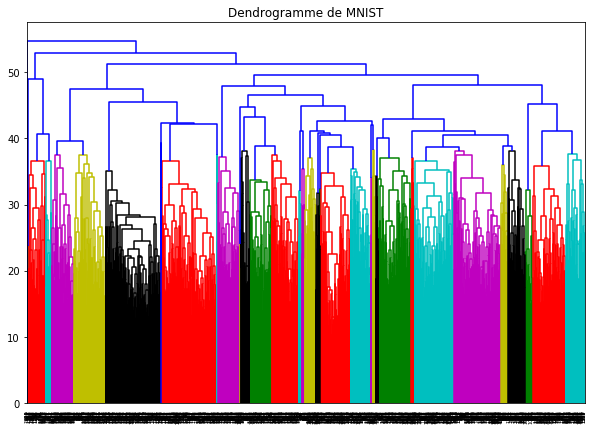

In [114]:
from scipy import ndimage
import scipy.cluster.hierarchy as shc

from time import time
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
#, datasets
from scipy import ndimage
import scipy.cluster.hierarchy as shc

targets = digits.target
mnist = digits.data
#creer le dendrogramme
plt.figure(figsize=(10,7))
plt.title("Dendrogramme de MNIST")
dend = shc.dendrogram(shc.linkage(digits.data, method='average'))
plt.show()

La matrice des données apres transformation par Spectral Embedding : 
 [[ 4.01823452e-03 -2.08531997e-03 -2.32478899e-03 ...  2.73407918e-04
   1.82096728e-04  1.39488011e-04]
 [-1.01921966e-03  1.26646228e-03 -4.14580225e-04 ...  4.43432614e-03
   3.94865488e-04 -1.13557813e-03]
 [-1.08016664e-03  8.49042264e-04 -1.55203892e-04 ...  4.20878045e-03
   3.44012679e-04  7.43556626e-04]
 ...
 [-8.01064836e-04  9.26745028e-04  1.11216853e-04 ...  3.75292609e-03
  -1.28664336e-03  5.92626060e-04]
 [ 1.16333613e-04 -1.53255923e-03  1.92499524e-04 ...  1.03693223e-03
   2.04546238e-03 -1.57227761e-03]
 [-2.95060471e-05  2.63058572e-04  1.52996371e-03 ...  1.63936955e-03
  -7.63627883e-04  1.26854568e-03]] 

Temps de calcul : 0.05 secondes
Score V-mesure : 0.7583792538211797
Score de precision : 0.06566499721758487
Score silhouette : 0.4036185426777989


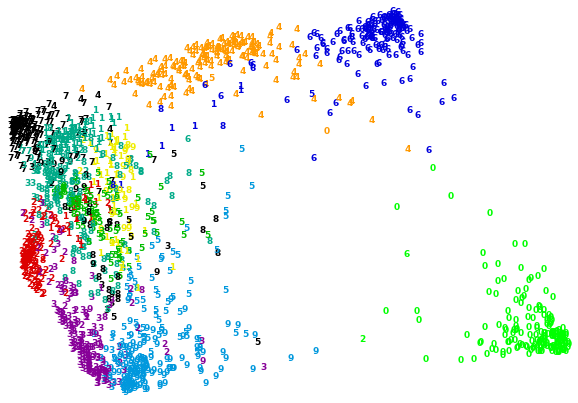

In [115]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold, datasets
#Creer matrice de similarite avec les donnees de mnist
mnist_matrix = manifold.SpectralEmbedding(n_components=9).fit_transform(mnist)
print("La matrice des données apres transformation par Spectral Embedding : \n", mnist_matrix,"\n")
#Creer le cluster
cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='average')
t0 = time()
cluster.fit(mnist_matrix)

#Calculer temps de calcul
temps = time() - t0
print("Temps de calcul :", round(temps,2), "secondes")

#Normalization du dataset
mnist_min, mnist_max = np.min(mnist_matrix, axis=0), np.max(mnist_matrix, axis=0)
mnist_matrix = (mnist_matrix - mnist_min) / (mnist_max - mnist_min)

#Afficher le cluster
plt.figure(figsize=(10,7))
for i in range(mnist_matrix.shape[0]):
    plt.text(mnist_matrix[i, 0], mnist_matrix[i, 1], str(targets[i]),
    color=plt.cm.nipy_spectral(cluster.labels_[i] / 10.),
    fontdict={'weight': 'bold', 'size': 9})

plt.axis('off')

#Calculer score v-mesure
from sklearn.metrics.cluster import v_measure_score
print("Score V-mesure :", v_measure_score(targets,cluster.labels_))

#Calculer score de precision
from sklearn.metrics import precision_score
print("Score de precision :", precision_score(targets, cluster.labels_, average='micro'))

#Calculer score silhouette
from sklearn.metrics import silhouette_score
print("Score silhouette :", silhouette_score(mnist_matrix, targets))

In [116]:
#Calcule les scores de V_measure et silhouette pour les model Random et Kmeans++ passé en paramètre
def extractScore(mlRandom,mlMeanplus,mlPartBindata,data):
    #V_measure
             #pour Kmeans aléatoire
    randomVm = metrics.v_measure_score(labels, mlRandom.labels_)
              #pour Kmeans++
    meanplusVm = metrics.v_measure_score(labels, mlMeanplus.labels_)
              #pour Partitionnement Binaire
    partBinVm = metrics.v_measure_score(labels, mlPartBindata.labels_)
    vmScore = [randomVm,meanplusVm,partBinVm]
    #Silhouette
                #pour Kmeans aléatoire
    randomSl = metrics.silhouette_score(data, mlRandom.labels_, metric='euclidean', sample_size=n_samples)
                #pour Kmeans++
    meanplusSl = metrics.silhouette_score(data, mlMeanplus.labels_, metric='euclidean', sample_size=n_samples)
                #pour Partitionnement Binaire
    partBinSl = metrics.silhouette_score(data, mlPartBindata.labels_, metric='euclidean', sample_size=n_samples)
    silhScore = [randomSl,meanplusSl,partBinSl]
    #Score Precision
                #pour Kmeans aléatoire
    #randomPrec = metrics.precision_score(targets, mlRandom.labels_)
                #pour Kmeans++
    #meanplusPrec = metrics.precision_score(targets, mlMeanplus.labels_)
                #pour Partitionnement Binaire
    #partBinPrec = metrics.precision_score(targets, mlPartBindata.labels_)
    #precScore = [randomPrec,meanplusPrec,partBinPrec]

    return vmScore,silhScore
def partScore(modell,datas):
    vMesure = metrics.v_measure_score(labels, modell.labels_)
    silh = metrics.silhouette_score(datas, modell.labels_, metric='euclidean', sample_size=n_samples)
    return vMesure,silh
# Benchmark sur k-moyennes, en utilisant la distance euclidienne comme metrique de mesure de performance
# Bench de perf sur la taille des echantillons MNIST DEPUIS Scikitlearn (echantillon reduit)
def banc_essai_kmeans(vm,pl,temps,name):
    print('%-9s\t%.5fs\t%.3f\t\t%.3f'
          % (name, temps,vm,pl))
def banc_essai_knn(estimator, name, data, metric):
    (trainData, testData, trainLabels, testLabels) = train_test_split(np.array(digits.data), digits.target, test_size=0.25, random_state=np.random.seed(56))
    t0 = time.time()
    #On entraine le classificateur
    modele = estimator
    modele.fit(trainData, trainLabels)
    # Calcule les predictions de chaque chiffre
    predictions = modele.predict(testData)
    t1 = time.time() - t0
    # Affiche la precision de chaque chiffre determine
    print(classification_report(testLabels, predictions))
    print('Temps: %.5fs' % (t1))

# Notre implémentation d'un algorithme de similarité

### Implementation d'une mélange de Gaussienne
Pour la notion de similarité, nous avons repris ce que nous avons appris en explorant les performances et resultats de l'algorithme de regroupement hiérarchique, et les notions de mélange de Gaussienne. La similirité se base donc sur la maximisation de l'esperance entre entre les features des images, par rapport a ce que l'algorithme doit trouver.

Une partie du code s'inspire de l'exemple sur Scikit-learn de "melange de Gausssienne" avec le jeu de données Iris, pour représenter les élipsoides.

L'utilisation de stratified k-fold nous permet de sepraer notre jeu de données en un ensenble d'apprentissage et un ensemble de validation. Nous voulions essayer d'obtenir une division du jeu de données en utilisant une autre méthode que nous n'avions pas vu au cours par curiosité.

C'est une technique de validation croisee, basé sur une technique d’échantillonnage. Le but de cette technique est d'essayer a partir d'un echantillon statistique de données, de généraliser a un ensemble de données indépendant. 

Cette approche pour la séparation du jeu de donnée est utile puisque rappelons-le, nous jouons avec un ensemble de donnée réduit de MNIST. Nous avons lors peu de marge de maneuvre pour faire en sorte que notre modele ne se trouve ni en sur-apprentissage, ni en sous-apprentissage.

Quand au nombre de *StratifiedKFold(n_splits=4)*, c'est a priori la division qui donne les meilleurs resultats au niveau de la precision sur les melanges de Gaussiennes, sauf lorsque la Gaussienne est 'Full'.
Nous fournissons quelques resultats avec differents niveaux de divisions apres avoir affiche les schemas de nos melanges de Gaussiennes.



La matrice apres reduction Spectrale :
 [[ 4.01823452e-03 -2.08531997e-03 -2.32478899e-03 ...  1.82096728e-04
   1.39488011e-04 -1.52027810e-04]
 [-1.01921966e-03  1.26646228e-03 -4.14580225e-04 ...  3.94865488e-04
  -1.13557813e-03 -3.12805512e-03]
 [-1.08016664e-03  8.49042264e-04 -1.55203892e-04 ...  3.44012679e-04
   7.43556626e-04  1.82258327e-03]
 ...
 [-8.01064836e-04  9.26745028e-04  1.11216853e-04 ... -1.28664336e-03
   5.92626060e-04  3.30991483e-03]
 [ 1.16333613e-04 -1.53255923e-03  1.92499524e-04 ...  2.04546238e-03
  -1.57227761e-03  3.42988848e-03]
 [-2.95060471e-05  2.63058572e-04  1.52996371e-03 ... -7.63627883e-04
   1.26854568e-03  5.14479801e-03]]
La matrice de covariance apres normalisation
 [[0.93942032 0.12407337 0.11623797 ... 0.29486824 0.45892881 0.34922578]
 [0.12946761 0.68249187 0.38513931 ... 0.31344041 0.35513599 0.09718982]
 [0.11966818 0.61294825 0.42165189 ... 0.30900156 0.50810115 0.51645307]
 ...
 [0.16454388 0.6258938  0.45915611 ... 0.16666481 0.49

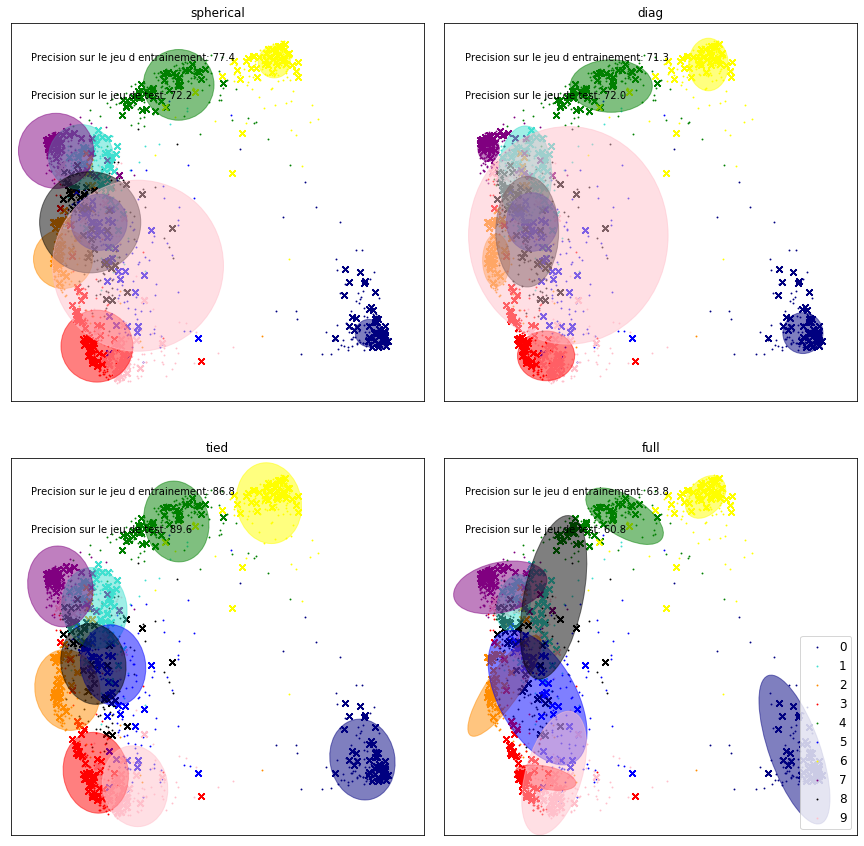

In [117]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn import manifold, datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import precision_score
from sklearn.metrics import silhouette_score
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green', 'blue', 'yellow', 'purple', 'black', 'pink']
#Pour afficher les elipses sur le graphe, inspire de l'exemple de Scikit-learn
def make_ellipses(gmm, ax):
	for n, color in enumerate(colors):
		if gmm.covariance_type == 'full':
			covariances = gmm.covariances_[n][:2, :2]
		elif gmm.covariance_type == 'tied':
			covariances = gmm.covariances_[:2, :2]
		elif gmm.covariance_type == 'diag':
			covariances = np.diag(gmm.covariances_[n][:2])
		elif gmm.covariance_type == 'spherical':
			covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
		v, w = np.linalg.eigh(covariances)
		u = w[0] / np.linalg.norm(w[0])
		angle = np.arctan2(u[1], u[0])
		angle = 180 * angle / np.pi  # convert to degrees
		v = 2. * np.sqrt(2.) * np.sqrt(v)
		ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
								  180 + angle, color=color)
		ell.set_clip_box(ax.bbox)
		ell.set_alpha(0.5)
		ax.add_artist(ell)
		ax.set_aspect('equal', 'datalim')
mnist = datasets.load_digits()
data = mnist.data
targets = mnist.target
## Seprarer le jeu de donnees (75%) test (25%) validation sets.
#Reduction de dimentionnalite en utilisant StratifiedKFold
# 4 Divisions est la valeur qui semble nous donner les meilleurs resultats sur les differentes
# methodes de melange de Gaussiennes
skf = StratifiedKFold(n_splits=4)
## Only take the first fold.
train_index, test_index = next(iter(skf.split(mnist.data, mnist.target)))
#Creer matrice de similarite avec les donnees de mnist, on sait deja que l'on a 10 classes
# On se sert de ce que l'on a trouve au regroupement hierarchique pour normaliser les donnees et les reduire
mnist_matrix = manifold.SpectralEmbedding(n_components=10).fit_transform(data)
print("La matrice apres reduction Spectrale :\n", mnist_matrix)
#Normalisation du dataset
mnist_min, mnist_max = np.min(mnist_matrix, axis=0), np.max(mnist_matrix, axis=0)
mnist_matrix = (mnist_matrix - mnist_min) / (mnist_max - mnist_min)
print("La matrice de covariance apres normalisation\n", mnist_matrix)
X_train = mnist_matrix[train_index]
train_labels = mnist.target[train_index]
X_test = mnist_matrix[test_index]
test_labels = mnist.target[test_index]
n_classes = len(np.unique(train_labels))
print("Nb de classes : ", n_classes)
## On essaie les differents types de melange de Gaussiennes
estimators = {cov_type: GaussianMixture(n_components=n_classes,
							covariance_type=cov_type, max_iter=50, random_state=0)
							for cov_type in ['spherical', 'diag', 'tied', 'full']}
n_estimators = len(estimators)
print("Estimateurs : ", n_estimators)
plt.figure(figsize=(12, 12))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
					left=.01, right=.99)
for index, (name, estimator) in enumerate(estimators.items()):
	# On connait les donnees categorielles que l'on essaie de classer
	# Nous sommes donc dans un apprentissage supervise et nous pouvons nous permettre
	# de donner des hyperparametres au modele, soit les chiffres de 0 a 9
	estimator.means_init = np.array([X_train[train_labels == i].mean(axis=0)for i in range(n_classes)])
	# On entrenne le modele selon l'algorithme de mximisation de l'esperance (EM)
	estimator.fit(X_train)
	# On dessine les elipses consequentes
	h = plt.subplot(2, n_estimators // 2, index + 1)
	make_ellipses(estimator, h)
	#Enumerer les couleurs pour rendre la lecture du graphe plus facile
	for n, color in enumerate(colors):
		data = mnist_matrix[mnist.target == n]
		plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,label=mnist.target_names[n])
					
	# Les donnees issues de l'ensemble d'apprentissage sont representees par des 'x'
		for n, color in enumerate(colors):
			data = X_test[test_labels == n]
			plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
	
	t0 = time.time()
	train_labels_pred = estimator.predict(X_train)
	train_accuracy = np.mean(train_labels_pred.ravel() == train_labels.ravel()) * 100
	test_labels_pred = estimator.predict(X_test)
	tempsCalcul = (time.time() - t0)
	test_accuracy = np.mean(test_labels_pred.ravel() == test_labels.ravel()) * 100

	# Afficher les donnees
	plt.text(0.05, 0.9, 'Precision sur le jeu d entrainement: %.1f' % train_accuracy, transform=h.transAxes)
	print('_'*82)
	print("Gaussienne '%s' " % name)
	print('Precision sur le jeu d entrainement : %.1f' % train_accuracy)
	plt.text(0.05, 0.8, 'Precision sur le jeu de test: %.1f' % test_accuracy,transform=h.transAxes)
	print("Precision sur le jeu de test : %.1f" % test_accuracy)
	print("V-mesure (Test): ", v_measure_score(train_labels, train_labels_pred))
	print("Temps de calcul : %.5f s" % tempsCalcul)
	plt.xticks(())
	plt.yticks(())
	plt.title(name)
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

### Le taux de precision en fonction du nombre de splits en parametre pour stratifiedKFolds()

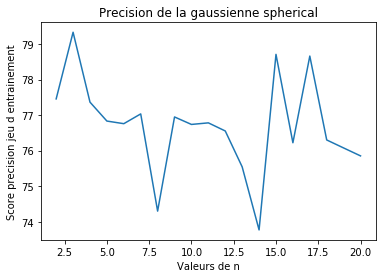

Vecteur des valeurs de precisions sur le jeu d entrainement
[77.45535714285714, 79.3305439330544, 77.36411020104245, 76.8318213538032, 76.75820495646349, 77.03318152244633, 74.2984693877551, 76.94723618090453, 76.73697270471465, 76.78132678132678, 76.55298416565165, 75.54347826086956, 73.76950780312124, 78.70813397129187, 76.2216924910608, 78.66034380557203, 76.30023640661938, 76.07542722451385, 75.85193889541716]


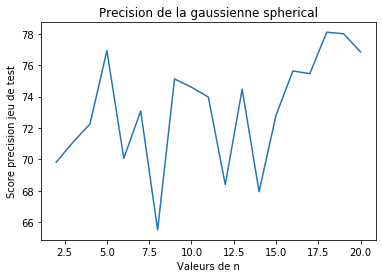

Vecteur des valeurs de precisions sur le jeu de test
[69.81132075471697, 71.09634551495017, 72.24669603524228, 76.92307692307693, 70.06578947368422, 73.07692307692307, 65.50218340611353, 75.1219512195122, 74.5945945945946, 73.96449704142012, 68.38709677419355, 74.46808510638297, 67.93893129770993, 72.8, 75.63025210084034, 75.45454545454545, 78.0952380952381, 78.0, 76.84210526315789]


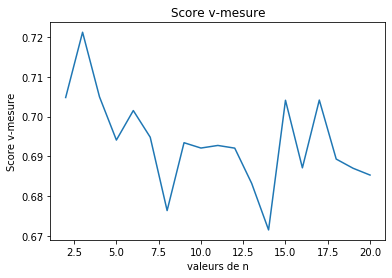

Vecteur des valeurs du Score V-mesure sur le jeu de test
[0.7048202828386966, 0.7212527699887271, 0.7049945697060861, 0.6941091592412467, 0.7015362154406536, 0.6948281112568367, 0.6763568100023981, 0.693440052839457, 0.692098735244668, 0.6927514098478894, 0.692074983668713, 0.6832037480864935, 0.6714858586637745, 0.7041259906860841, 0.6871159415899007, 0.7041752582247667, 0.6893203810125127, 0.6870039616225744, 0.6852966647998168]


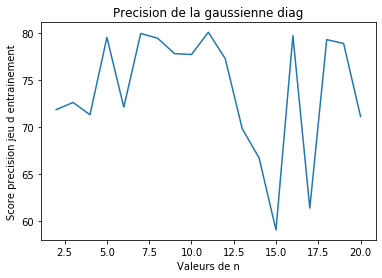

Vecteur des valeurs de precisions sur le jeu d entrainement
[71.875, 72.63598326359832, 71.33283693224125, 79.55338450802513, 72.13663764233088, 79.96096291476903, 79.46428571428571, 77.82663316582915, 77.72952853598015, 80.0982800982801, 77.28380024360536, 69.8671497584541, 66.74669867947179, 59.09090909090909, 79.7377830750894, 61.41078838174274, 79.3144208037825, 78.90394814378314, 71.15158636897768]


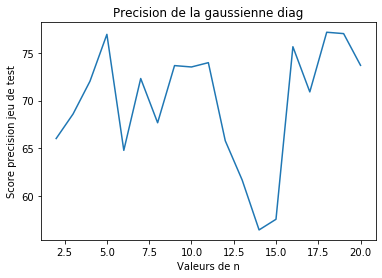

Vecteur des valeurs de precisions sur le jeu de test
[66.0377358490566, 68.6046511627907, 72.02643171806167, 76.92307692307693, 64.80263157894737, 72.3076923076923, 67.68558951965066, 73.65853658536585, 73.51351351351352, 73.96449704142012, 65.80645161290323, 61.702127659574465, 56.48854961832062, 57.599999999999994, 75.63025210084034, 70.9090909090909, 77.14285714285715, 77.0, 73.68421052631578]


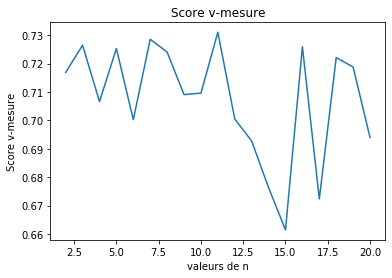

Vecteur des valeurs du Score V-mesure sur le jeu de test
[0.7168704529237636, 0.7264819853972504, 0.7066199102448515, 0.7253335867333093, 0.7002183303448053, 0.7285651328348036, 0.7240642223436281, 0.7090684573660487, 0.7096035166914575, 0.7310422758726823, 0.700488753066369, 0.6927095069397287, 0.6763034304929584, 0.6614013043853731, 0.7259244252033954, 0.6723314264551011, 0.7221270475425117, 0.7187674594407059, 0.6939492931710611]


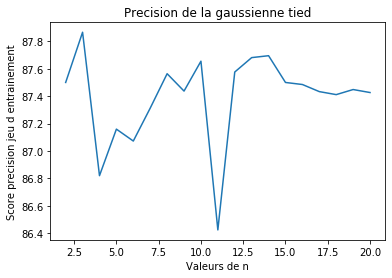

Vecteur des valeurs de precisions sur le jeu d entrainement
[87.5, 87.86610878661088, 86.82055100521221, 87.15980460572226, 87.073007367716, 87.31294729993493, 87.56377551020408, 87.43718592964824, 87.65508684863524, 86.42506142506143, 87.57612667478685, 87.68115942028986, 87.69507803121247, 87.5, 87.48510131108462, 87.43331357439241, 87.41134751773049, 87.44843842074249, 87.42655699177439]


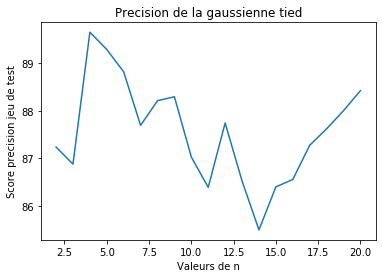

Vecteur des valeurs de precisions sur le jeu de test
[87.23640399556048, 86.87707641196013, 89.64757709251101, 89.28571428571429, 88.81578947368422, 87.6923076923077, 88.20960698689956, 88.29268292682927, 87.02702702702703, 86.3905325443787, 87.74193548387098, 86.52482269503547, 85.49618320610686, 86.4, 86.5546218487395, 87.27272727272727, 87.61904761904762, 88.0, 88.42105263157895]


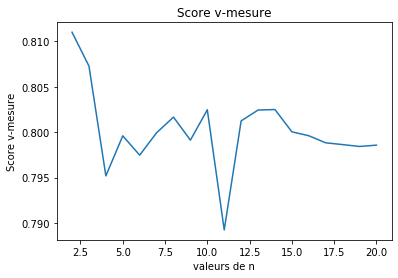

Vecteur des valeurs du Score V-mesure sur le jeu de test
[0.8109988067790299, 0.8072795904412295, 0.795192918133, 0.7995989723744035, 0.7974751196712815, 0.7999362966945457, 0.801661207723223, 0.7991262263158903, 0.8024647617423188, 0.7892476328448914, 0.8012405848979338, 0.8024391900267553, 0.8024943773874217, 0.8000436628137612, 0.7996120041587955, 0.7988328368034677, 0.7986364754982362, 0.7984304451574477, 0.7985750397947416]


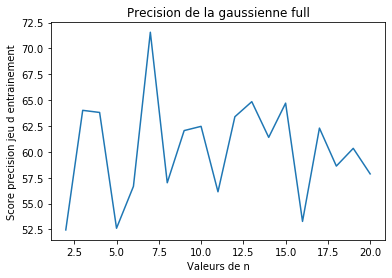

Vecteur des valeurs de precisions sur le jeu d entrainement
[52.45535714285714, 64.01673640167364, 63.812360387192854, 52.6168876482903, 56.66443402545212, 71.5679895901106, 57.01530612244898, 62.06030150753769, 62.468982630272954, 56.14250614250614, 63.398294762484774, 64.85507246376811, 61.404561824729896, 64.71291866028707, 53.2777115613826, 62.29994072317724, 58.62884160756501, 60.34177961107837, 57.873090481786136]


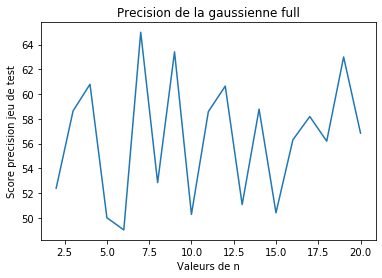

Vecteur des valeurs de precisions sur le jeu de test
[52.38623751387348, 58.63787375415283, 60.792951541850215, 50.0, 49.01315789473684, 65.0, 52.838427947598255, 63.41463414634146, 50.27027027027027, 58.57988165680473, 60.64516129032258, 51.06382978723404, 58.778625954198475, 50.4, 56.30252100840336, 58.18181818181818, 56.19047619047619, 63.0, 56.84210526315789]


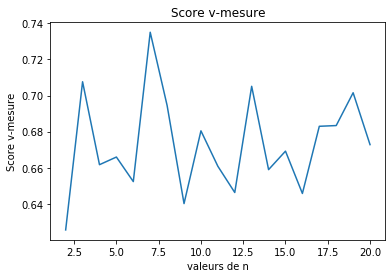

Vecteur des valeurs du Score V-mesure sur le jeu de test
[0.6255180228307722, 0.7076433397877516, 0.6616712031339796, 0.6659117082409368, 0.6523022572164536, 0.7350816500561983, 0.6944631880051222, 0.640107975346801, 0.6804384565406506, 0.6608096228994901, 0.6462553718813472, 0.7051168156832256, 0.6589345854669473, 0.669178736960436, 0.6457181658280082, 0.6829525171145221, 0.6833588074025629, 0.7015464430916639, 0.672786556065617]


In [118]:
mnist = datasets.load_digits()
data = mnist.data
targets = mnist.target
ct = ['spherical', 'diag', 'tied', 'full']

# On recalcule des modeles de gaussiennes et accumule toutes les metriques dans un vecteur
def performanceNombreFolds(n_splits, cov_type, results_entrainement_list, results_test_precision,  results_vmesure, 
                           X_train_metric, train_labels_metric, X_test_metric, test_labels_metric):
    estimator = GaussianMixture(n_components=n_classes,covariance_type=cov_type, max_iter=50, random_state=0)
    estimator.means_init = np.array([X_train_metric[train_labels_metric == i].mean(axis=0) for i in range(n_classes)])
    estimator.fit(X_train_metric)
    train_labels_pred_metric = estimator.predict(X_train_metric)
    train_accuracy_metric = np.mean(train_labels_pred_metric.ravel() == train_labels_metric.ravel()) * 100
    results_entrainement_list.append(train_accuracy_metric)
    test_labels_pred_metric = estimator.predict(X_test_metric)
    test_accuracy_metric = np.mean(test_labels_pred_metric.ravel() == test_labels_metric.ravel()) * 100
    results_test_precision.append(test_accuracy_metric)
    results_vmesure.append(v_measure_score(train_labels_metric, train_labels_pred_metric))

#On effectue plusieurs fois le type de melange de gaussienne avec des jeux de donnees de taille differente
def returnEstimatorPerforances(estimator_name):
    precision_test = []
    precision_entrainement = []
    results_vmesure = []
    n_range = range(2,21)
    for n in n_range:
        skf = StratifiedKFold(n_splits=n)
        train_index_metric, test_index_metric = next(iter(skf.split(mnist.data, mnist.target)))
        mnist_matrix_metric = manifold.SpectralEmbedding(n_components=10).fit_transform(data)
        mnist_min_metric, mnist_max_metric = np.min(mnist_matrix_metric, axis=0), np.max(mnist_matrix_metric, axis=0)
        mnist_matrix_metric = (mnist_matrix_metric - mnist_min_metric) / (mnist_max_metric - mnist_min_metric)
        X_train_metric = mnist_matrix_metric[train_index_metric]
        train_labels_metric = mnist.target[train_index_metric]
        X_test_metric = mnist_matrix_metric[test_index_metric]
        test_labels_metric = mnist.target[test_index_metric]
        n_classes = len(np.unique(train_labels))
        n_estimators = len(estimators)
        performanceNombreFolds(n, estimator_name, precision_entrainement, precision_test, results_vmesure,
                              X_train_metric, train_labels_metric, X_test_metric, test_labels_metric)

    plt.plot(n_range, precision_entrainement)
    plt.xlabel('Valeurs de n')
    plt.ylabel('Score precision jeu d entrainement')
    plt.title('Precision de la gaussienne %s' % estimator_name);
    plt.show()
    print("Vecteur des valeurs de precisions sur le jeu d entrainement")
    print(precision_entrainement)
    plt.plot(n_range, precision_test)
    plt.xlabel('Valeurs de n')
    plt.ylabel('Score precision jeu de test')
    plt.title('Precision de la gaussienne %s' % estimator_name);
    plt.show()
    print("Vecteur des valeurs de precisions sur le jeu de test")
    print(precision_test)
    plt.plot(n_range, results_vmesure)
    plt.xlabel('valeurs de n')
    plt.ylabel('Score v-mesure')
    plt.title('Score v-mesure');
    plt.show()
    print("Vecteur des valeurs du Score V-mesure sur le jeu de test")
    print(results_vmesure)
   
   
for i in range(len(ct)):
    returnEstimatorPerforances(ct[i])
    

Comme on peut le constater, les meilleurs scores sont obtenus avec un nombre *n_fold <= 10*. Puisque nous voyons que tres peu de differencence au dela de 4 fold sur la globalité des resultats de differents melanges de Gaussiennes, nous avons decide de rester avec *n_fold = 4* pour diminuer au plus les temps de traitement des données.

# Bancs d'essais et analyses de performance par rapport aux autres algorithmes

On comparera notre algorithme par rapport au autres en analysant les metriques suivantes :

    - Temps de calcul de chaque algorithme sans et avec transmformation des données
    - Valeur sur le score Silhouette
    - Valeur sur la V-mesure
    - Taux de precision

Certaines transformations prennent du temps. Les calculs tels qu'ils apparaissent sans relancer le notebook on ete compilés sur une machine de bureau assez performante (i7-6700k)

In [119]:
#Isomap
def IsoMap(donnee,nbFeature,nbNeighbors,returnError = False):
    isomapp = manifold.Isomap(n_neighbors=nbNeighbors, n_components=nbFeature, eigen_solver='auto')
    startTime = time.time()
    dataIso =  isomapp.fit_transform(donnee)
    isoTime = time.time() - startTime
    error = isomapp.reconstruction_error()
    if returnError:
        return dataIso, isoTime,error
    else:
        return dataIso, isoTime 
#PCoA
def PCoA(donnee,nbFeature,nb_init=4, maxx_iter=300,returnError = False):
    pcoaa = manifold.MDS(n_components=nbFeature, metric=True,n_init=nb_init, max_iter=maxx_iter, random_state=None)
    startTime = time.time()
    dataPcoa =pcoaa.fit_transform(donnee)
    pcoaTime = time.time() - startTime
    error = pcoaa.stress_
    if returnError:
        return dataPcoa, pcoaTime,error
    else:
        return dataPcoa, pcoaTime
def modelExtract(datta):
    #K-means aleatoire
    modeleRandom = KMeans(init='random', n_clusters=n_digits, n_init=10)
    t0 = time.time()
    modeleRandom.fit(datta)
    tempsRandom = (time.time() - t0)
    #k-means++
    modelePlus = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
    t0 = time.time()
    modelePlus.fit(datta)
    tempsPlus = (time.time() - t0)
    #Partitionnement Binaire
    modeleBin = AgglomerativeClustering(n_clusters=n_digits, affinity='euclidean', linkage='average')
    t0 = time.time()
    modeleBin.fit(datta)
    tempsBin = (time.time() - t0)
    return [modeleRandom,tempsRandom,'KmeanRandom\t'],[modelePlus,tempsPlus,'Kmean++\t\t'],[modeleBin,tempsBin,'PartBinaire\t']
    
def performance(isoVal = None,pcVal=None):
    # On peut utiliser init=random pour k-means, mais on veut obtenir la meme seed pour comparer
    # les performances de maniere consistente
    print('Algorithme\t\tTemps\t     V-mesure\tScore Silhouette') # on se concentre sur le temps pris par l'algo, la perf et ce que l'on a vu en demo
    #score silhouette des donnees (demo), v-mesure (cours)
    #k-means a besoin d'une valeur initiale pour determiner la position des centroides
    #Dans la documentation de scikit-learn, il y a quelques manieres de faire, notemment
    #k-means++, ou une seed aleatoire qui placera les centroides de maniere aleatoire
    
    #K-means sans reduction de dimensionalite
    rand,plus,binn = modelExtract(digits.data)
    #randommVm,randommSl,meanplussVm,meanplussSl = extractScore(rand[0],plus[0],binn[0],data)
    vmScores,silhScores = extractScore(rand[0],plus[0],binn[0],data)
    #tempsRand = rand[1]
    #tempsPlus = plus[1]
    banc_essai_kmeans(vmScores[0],silhScores[0],rand[1],name="random\t\t")
    banc_essai_kmeans(vmScores[1],silhScores[1],plus[1],name="k-means++\t")
    banc_essai_kmeans(vmScores[2],silhScores[2],binn[1],name="PartBinaire\t")
    
    if isoVal != None:
        isoVall = isoVal[0]
        isoTimme = isoVal[1]        
        banc_essai_kmeans(isoVall['vm','rand'][1],isoVall['sil','rand'][1],isoTimme['rand'],name="IsoMap_random\t")
        banc_essai_kmeans( isoVall['vm','plus'][1],isoVall['sil','plus'][1],isoTimme['plus'],name="IsoMap_k-means++")
        banc_essai_kmeans( isoVall['vm','bin'][1],isoVall['sil','bin'][1],isoTimme['bin'],name="IsoMap_PartBinaire")

        pcoVall = pcVal[0]
        pcoTimme = pcVal[1]        
        banc_essai_kmeans(pcoVall['vm','rand'][1],pcoVall['sil','rand'][1],pcoTimme['rand'],name="Pcoa_random\t")
        banc_essai_kmeans( pcoVall['vm','plus'][1],pcoVall['sil','plus'][1],pcoTimme['plus'],name="Pcoa_k-means++\t")
        banc_essai_kmeans( pcoVall['vm','bin'][1],pcoVall['sil','bin'][1],pcoTimme['bin'],name="Pcoa_k_PartBinaire")
    
def afficherGraph(x_reduit, name="", time=0, error=0):
     
    rand,plus,binn = modelExtract(x_reduit)
    modeles = [rand,plus,binn]
    vmScores,silhScores = extractScore(rand[0],plus[0],binn[0],data)
    #Normalization du dataset
    #mnist_min, mnist_max = np.min(mnist_matrix, axis=0), np.max(mnist_matrix, axis=0)
    #x_reduit = (x_reduit - mnist_min) / (mnist_max - mnist_min)
    x_reduit = (x_reduit - np.min(x_reduit, 0)) / ( np.max(x_reduit, 0) -  np.min(x_reduit, 0))
    print('       %-9s  Temps: %.5fs, Erreur: %.3e'
          % (name, time,error))
    plt.figure(figsize=(10,7))
    ax = plt.subplot(111)
    for i in range(x_reduit.shape[0]):
        plt.text(x_reduit[i, 0], x_reduit[i, 1], str(labels[i]),
                 color=plt.cm.Set1(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 8})

    #plt.xticks([]), plt.yticks([])
    plt.axis('off')
    plt.title("{}, time: {:.3f}s, error: {:.3e}".format(name, time, error))
    plt.show()
    print(82 * '_')
    
    #Afficher le cluster
    for model in modeles:
        print('Algorithme\t\tTemps\t     V-mesure\tScore Silhouette')
        plt.figure(figsize=(10,7))
        for i in range(x_reduit.shape[0]):
            plt.text(x_reduit[i, 0], x_reduit[i, 1], str(labels[i]),
            color=plt.cm.nipy_spectral(model[0].labels_[i] / 10.),
            fontdict={'weight': 'bold', 'size': 9})
            #plt.title("Partition: {}, temps: {:.3f}s".format(model[2], model[1]))
        plt.axis('off')
        vm,sil = partScore(model[0],x_reduit)
        banc_essai_kmeans(vm,sil,model[1],name=model[2])
        plt.show()
        print(82 * '_')

In [120]:
def testerBestFeature(estIso=True):
    randVm = []  #Contient V-Mesure pour Kmeans Random pour tout les nombre de freatures
    randSl = []  #Contient score Silhoueete pour Kmeans Random pour tout les nombre de freatures
    plusVm = []  #Contient V-Mesure pour Kmeans++ pour tout les nombre de freatures
    plusSl = []  #Contient score Silhoueete pour Kmeans++ pour tout les nombre de freatures
    binVm = []   #Contient V-Mesure pour PartBinaire pour tout les nombre de freatures
    binSl = []   #Contient score Silhoueete pour PartBinaire pour tout les nombre de freatures
    tableTemps = [] #Contient des dict (['plus' = fitTime Kmeans++, 'rand' = fitTime Kmeans Random])
    tableErreur = []
    # loop over featureVal
    vide = np.array([])
    for nbComp in compVals: #Pour chaque nb feature {1,64}
        dataa = vide #empecher erreur reutilisation
        #Si vrai, alors utiliser Isomap
        if estIso:
            dataa,temps,erreurs = IsoMap(digits.data,nbFeature=nbComp,nbNeighbors=275,returnError = True)
            #print("Temps Isomap: " + str(temps) + "pour nb feature: "+str(nbComp))
        #Sinon utiliser PCoA
        else:
            dataa,temps,erreurs = PCoA(digits.data,nbFeature=nbComp,nb_init=2, maxx_iter=200,returnError = True)
            print("Temps PCoA: " + str(temps) + "s pour nb feature: "+str(nbComp))
        #random et meanplus sont de format (model,temps)
        tableErreur.append(erreurs)
        random,meanplus,partBin = modelExtract(dataa)
        #Calculer les scores VMeasure et PCoA
        vmScores,silhScores = extractScore(random[0],meanplus[0],partBin[0],dataa)
        #Ajouter dans chacun des tableau specifique
        randVm.append(vmScores[0])
        randSl.append(silhScores[0])
        plusVm.append(vmScores[1])
        plusSl.append(silhScores[1])
        binVm.append(vmScores[2])
        binSl.append(silhScores[2])        
        dictTemps = {}
        dictTemps['rand'] = random[1] #Temps pour fit Kmeans random
        dictTemps['plus'] = meanplus[1] #Temps pour fit Kmeans++
        dictTemps['bin'] = partBin[1] #Temps pour fit Kmeans++
        tableTemps.append(dictTemps) #Ajouter le dict dans la table
    return randVm,randSl,plusVm,plusSl,binVm,binSl,tableTemps,tableErreur
#Retourn le meilleur nombre feautre avec son score ainsi que le temps pour fit Kmeans(pour affichage)
def topFeatureValue(scoressVal,typeCluster=None,fitTimes=None):
    indexx = np.argmax(scoressVal)
    if fitTimes == None:
        return (compVals[indexx],scoressVal[indexx])
    else:
        if typeCluster == 'rand':
            timee = fitTimes[indexx]['rand']
        elif typeCluster == 'plus':
            timee = fitTimes[indexx]['plus']
        else:
            timee = fitTimes[indexx]['bin']
        return (compVals[indexx],scoressVal[indexx]),timee
#Affiche le graph de score avec les reductions en differents nombres de features
def afficheScore(scoresVal,typeScoreAlgo):
    print(typeScoreAlgo)
    plt.plot(compVals, scoresVal)
    plt.xlabel('nombre freatures')
    plt.ylabel('Scores')
    plt.title('Scores de ' +typeScoreAlgo+ ' en fonction nb features');
        
    # Retourne la plus grande precision
    topValues,topScore = topFeatureValue(scoresVal)
    #indexx = np.argmax(scoresVal)
    print("Le nombre de feature ayant le plus grand score est : nombre Features=%d avec Score=%f" % (topValues,topScore))
    plt.show()

In [121]:
#Pour la performance de l'algorithme, on utilise la distance de Minkowski qui 
#est quasi-equivalente a celle de la distance euclidienne (en deux dimensions), mais qui nous permet de calculer 
# une notion de distance lorsque nous avons plus de dimensions (notemment lorsque nous utilisons K-NN sans reduction)
print("Performance de l'algorithme knn")
banc_essai_knn(KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=5, p=2, weights='distance'), name="KNeighbors", data=data, metric='euclidean')

Performance de l'algorithme knn
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        44
           3       0.98      1.00      0.99        41
           4       1.00      0.97      0.99        37
           5       0.98      0.98      0.98        49
           6       1.00      1.00      1.00        59
           7       0.98      1.00      0.99        42
           8       1.00      1.00      1.00        42
           9       0.98      0.95      0.96        42

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

Temps: 0.07791s


In [122]:
performance()

Algorithme		Temps	     V-mesure	Score Silhouette
random		 	0.12925s	0.751		0.188
k-means++		0.14059s	0.744		0.182
PartBinaire		0.11433s	0.713		0.147


# Optimisation en vue de la reduction

Le nombre de caractéristiques que l'on definit en hyperparametre va grandement impacter les resultats sur la performance et l'exactitude.
On fait alors quelques recherches (permises dans un temps raisonnable car le calcul est tres long) sur le nombre de caracteristiques que l'on veut garder.

In [ ]:
compVals = range(1, 11)
isoRandVm,isoRandSl,isoPlusVm,isoPlusSl,isoBinVm,isoBinSl,isoFitTime,isoErrors = testerBestFeature(estIso=True)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


In [ ]:
pcoRandVm,pcoRandSl,pcoPlusVm,pcoPlusSl,pcoBinVm,pcoBinSl,pcoFitTime,isoErrors = testerBestFeature(estIso=False)

In [ ]:
#Afficher le graph pour differents algo
print("Nombre de features pour Isomap")
print(82 * '_')
afficheScore(isoRandVm,"V-Mesure Random")
print(82 * '_')
afficheScore(isoRandSl,"Silhouette Random")
print(82 * '_')
afficheScore(isoPlusVm,"V-Mesure k-means++")
print(82 * '_')
afficheScore(isoPlusSl,"Silhouette k-means++")
print(82 * '_')
afficheScore(isoBinVm,"V-Mesure Partition Binaire")
print(82 * '_')
afficheScore(isoBinSl,"Silhouette Partition Binaire")
print(82 * '_')

In [ ]:
#Afficher le graph pour differents algo
print("nombre features pour PCoA")
print(82 * '_')
afficheScore(pcoRandVm,"V-Mesure Random")
print(82 * '_')
afficheScore(pcoRandSl,"Silhouette Random")
print(82 * '_')
afficheScore(pcoPlusVm,"V-Mesure k-means++")
print(82 * '_')
afficheScore(pcoPlusSl,"Silhouette k-means++")
print(82 * '_')
afficheScore(pcoBinVm,"V-Mesure Partition Binaire")
print(82 * '_')
afficheScore(pcoBinSl,"Silhouette Partition Binaire")
print(82 * '_')

In [ ]:
#Isomap
isoTopValue = {} #value = (FeatureValue, Score)  
isofitValue = {}
isoTopValue['vm','rand'],isofitValue['rand'] = topFeatureValue(isoRandVm,'rand',isoFitTime)
isoTopValue['sil','rand'] = topFeatureValue(isoRandSl)
isoTopValue['vm','plus'],isofitValue['plus'] = topFeatureValue(isoPlusVm,'plus',isoFitTime)
isoTopValue['sil','plus'] = topFeatureValue(isoPlusSl)
isoTopValue['vm','bin'],isofitValue['bin'] = topFeatureValue(isoBinVm,'bin',isoFitTime)
isoTopValue['sil','bin'] = topFeatureValue(isoBinSl)
isoTuple = (isoTopValue,isofitValue)
#PCoA
pcoRandVm,pcoRandSl,pcoPlusVm,pcoPlusSl,pcoFitTime
pcoTopValue = {} #value = (FeatureValue, Score)  
pcofitValue = {}
pcoTopValue['vm','rand'],pcofitValue['rand'] = topFeatureValue(pcoRandVm,'rand',pcoFitTime)
pcoTopValue['sil','rand'] = topFeatureValue(pcoRandSl)
pcoTopValue['vm','plus'],pcofitValue['plus'] = topFeatureValue(pcoPlusVm,'plus',pcoFitTime)
pcoTopValue['sil','plus'] = topFeatureValue(pcoPlusSl)
pcoTopValue['vm','bin'],pcofitValue['bin'] = topFeatureValue(pcoBinVm,'bin',pcoFitTime)
pcoTopValue['sil','bin'] = topFeatureValue(pcoBinSl)
pcoTuple = (pcoTopValue,pcofitValue)

In [ ]:
print("Affichage les scores avec la meilleur reduction pour chaque type de score\n")
performance(isoVal = isoTuple,pcVal=pcoTuple)

On essaie de diminuer le nombre d'erreur après réduction dimensionalité avec algo Isomap.
On utilise comme hyperparametre, le nombre de voisin

In [ ]:
'''
                 Test deja effectué et resultat enregistré dans des fichiers txt
import math
nbFeature = 2
errMin = math.inf
tablenbFeature = []
tableError = []
temp = 0
nbVoisin = 0
for nb in range(2,276):
    dataIso, isoTime,isoError =IsoMap(digits.data,nbFeature,nbNeighbors=nb,returnError = True)
    tablenbFeature.append(nb)
    tableError.append(isoError)
    if isoError < errMin:
        isoDonnes = dataIso.copy()
        temp = isoTime
        nbVoisin = nb
        #print(nb)
        errMin = isoError
        #print("error: {:.3e}".format(errMin))
'''
f = open('ResultTableTest/tablenbFeature.txt', "r")
nbFeatures = f.read().splitlines()
f.close()
f = open('ResultTableTest/tableError.txt', "r")
nbErreurs = f.read().splitlines()
f.close()
nbFeatures = list(map(int, nbFeatures))
nbErreurs = list(map(float, nbErreurs))
print("Test effectuer sur Isomap avec nombre de voisin entre 2 à 275")
print('Nombre voisin: %d avec le minimum erreur: %.3e'
          % (nbFeatures[len(nbFeatures)-1], nbErreurs[len(nbErreurs)-1]))
plt.plot(nbFeatures, nbErreurs)
plt.xlabel('nbVoisin')
plt.ylabel('Erreur')
plt.title('Nombre erreur Isomap en fonction nbVoisin');
#On réduit les dimension avec nombre de Feature = 2

# Affichage des donnée

Affichage les graph des donnée Mnist avec différents type d'algo Partition en utilisant la reduction Isomap

In [ ]:
'''
Affichage les graph des donnée Mnist avec différents type d'algo Partition en utilisant la reduction Isomap
'''
nombreFeature = 2
dataIso,isoTime,isoError = IsoMap(digits.data,nbFeature=nombreFeature,nbNeighbors=275,returnError = True)

In [ ]:
afficherGraph(dataIso, name="Isomap", time=isoTime, error=isoError)

In [ ]:
'''
Affichage les graph des donnée Mnist avec différents type d'algo Partition en utilisant la reduction PCoA
'''
nombreFeature = 2
dataPcoa, pcoaTime, pcoaError =PCoA(digits.data,nbFeature=nombreFeature,nb_init=2, maxx_iter=200,returnError = True)

In [ ]:
afficherGraph(dataPcoa, name="Multidimensional scaling (MDS)", time=pcoaTime, error=pcoaError)

# Conclusion

Notre melange de Gaussienne, bien que plus rapide que les algorithmes K-Meads, K-NN est bien moins precis et commet un peu plus d'erreus que ces derniers. En revanche, il est beaucoup plus precis par rapport au partitionnement binaire, qui lui offre de moins bon resultats, malgre le fait que nous ayont applique la meme normalisation sur notre ensemble de donnees avant tout calcul de l'algorithme.

Une des raisons s'explique par le fait que nous utilisons le jeu de données réduit de MNIST offert par scikit-learn, qui, bien qu'il soit tres pratique pour effectuer des petits test et comprendre rapidement ce qu'il se passe dans notre algorithme, n'offre pas assez d'exemples (nous pensons), pour le melange de gaussiennes. Il ne faut pas oublier que nous n'avons plus que 64 dimensions ( au lieu de 256*256 avec MNIST complet) et 1797 exemple au lieu des 60 000. Mais nous avons le choix de rester avec cet ensemble de données car nous estimions il etait difficile pour nous, ainsi que pour le correcteur de jouer avec l'ensemble complet de MNIST.

# Bibliographie :

### Pour notre alforithme de melange de gaussiennes avec Scikit-learn

https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://machinelearningmastery.com/k-fold-cross-validation/

https://www.geeksforgeeks.org/gaussian-mixture-model/

### Divers exemples de Scikit-learn pour apprendre a utiliser les librairies:

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

### La documentation de Scikit-learn pour comprendre comment utiliser les metriques :

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

https://github.com/mwguthrie/python_PCoA/blob/master/distance.py

https://github.com/PukkaPad/Recognizing-handwritten-digits-KNN/blob/master/MNIST_KNN_python.py

### Des exemples pour comprendre concretement les effets de la reduction dimensionalite et de la transformation des donnees :

https://blog.floydhub.com/introduction-to-k-means-clustering-in-python-with-scikit-learn/

https://github.com/wdlv/Clustering-on-the-MNIST-data/blob/master/Clustering_Classification.ipynb

https://stackoverflow.com/questions/10035752/elegant-python-code-for-integer-partitioning

https://github.com/shukali/dimensionality-reduction-comparison

https://www.python-course.eu/neural_network_mnist.php

https://www.geeksforgeeks.org/gaussian-mixture-model/

https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php

https://www.youtube.com/watch?v=REypj2sy_5U

https://github.com/drewwilimitis/Manifold-Learning/blob/master/Isomap.ipynb

https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php

https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7x

https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data

https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7